## Importing Libraries

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import itertools
from copy import deepcopy
import seaborn as sns
from torchvision import models

## Loading Dataset

In [2]:
data = datasets.ImageFolder(root= ".\dataset")

In [3]:
len(data)

6862

In [4]:
classes = data.classes
classes

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [5]:
num_classes = len(classes)
num_classes

11

The dataset consists of 6862 weather images with 11 different classes such as rain, snow and many others. The goal is to accurately classify the weather in any given image into one of these classes.

## Visualizing the dataset

### Original Dataset

In [6]:
orig_data = datasets.ImageFolder(root= ".\dataset",transform= None)

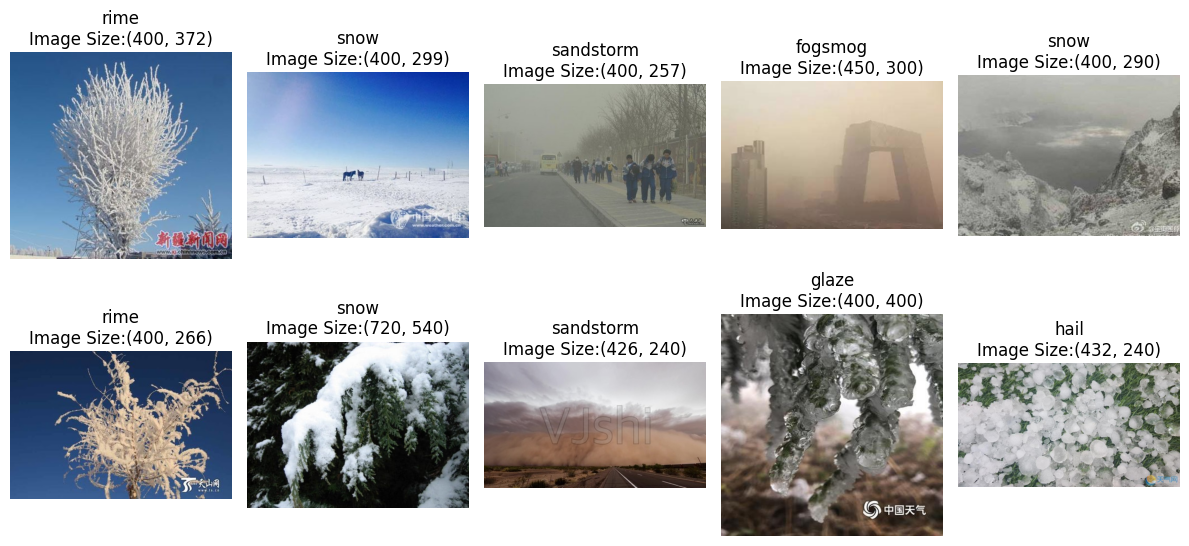

In [8]:
# Full dataset (ImageFolder)
num_images = 10

ncols = 5
nrows = int(np.ceil(num_images / ncols))

random_sampled_indices = np.random.randint(0, len(orig_data) - 1, num_images)

plt.figure(figsize=(12, 3 * nrows))
for i in range(num_images):
    image, label = orig_data[random_sampled_indices[i]]  # Get image and label from the tensor

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}\nImage Size:{image.size}")
    plt.axis("off")

plt.tight_layout()

`image.size` returns a 2-tuple containing the number of pixels horizontally and vertically, which defines the image resolution. In this dataset, the images have different resolutions, making it harder for the model to accurately learn and predict labels. Therefore, we need to resize all images to a uniform resolution before training the model. Moreover, we also apply random rotations and horizontal flip to randomly selected images to generalize our dataset.

In [9]:
# ImageNet normalization values
mean_img_net = np.array([0.485, 0.456, 0.406])
std_img_net = np.array([0.229, 0.224, 0.225])

#pre-processing the image data set
image_transforms=transforms.Compose([
    transforms.Resize((160, 160)),                              # 160x160 pixels in each image 
    transforms.RandomHorizontalFlip(0.2),                       # randomly flip 20% of images horizontally for better generalization
    transforms.RandomRotation(5),                               # randomly rotate images within 10 degrees for better generalization
    transforms.ToTensor(),                                      # Convert images to PyTorch tensors
    transforms.Normalize(mean=mean_img_net, std=std_img_net)    # Normalize to range [-1, 1]
])

In [10]:
data = datasets.ImageFolder(root= ".\dataset",transform= image_transforms)

In [11]:
def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]
    img = std_img_net * img + mean_img_net     # Denormalize
    img = np.clip(img, 0, 1)                   # Clip to [0,1] for display
    return img

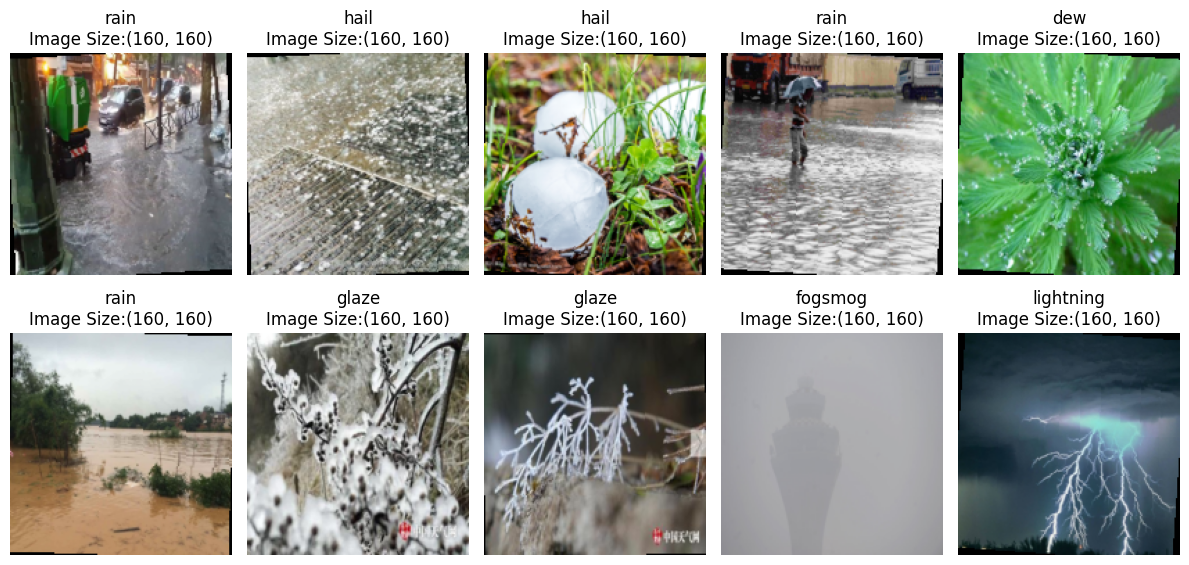

In [12]:
# Full dataset (ImageFolder)
num_images = 10

ncols = 5
nrows = int(np.ceil(num_images / ncols))

random_sampled_indices = np.random.randint(0, len(data) - 1, num_images)

plt.figure(figsize=(12, 3 * nrows))
for i in range(num_images):
    image, label = data[random_sampled_indices[i]]  # Get image and label from the tensor
    image = denormalize(image)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}\nImage Size:{image.shape[:-1]}")
    plt.axis("off")

plt.tight_layout()

## Splitting into train and test 

In [13]:
train_size = int(0.8 * len(data))  # 80% for training
test_size = len(data) - train_size  # 20% for testing
train_data, test_data = random_split(data, [train_size, test_size])

In [14]:
print("Size of training data:", len(train_data))
print("Size of test dataset:", len(test_data))

Size of training data: 5489
Size of test dataset: 1373


In [15]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [16]:
for i,(image,label) in enumerate(train_loader):
    print(image.shape)
    break

torch.Size([32, 3, 160, 160])


Each image tensor has size 160x160 with 3 channels (RGB channels). Here 32 indicates the default batch size.

## CNN with 1 Convolutional layer

We will use the following structure of CNN which 1 convolutional layer and 1 max-pooling layer:

$$
    \text{Conv}\rightarrow\text{MaxPool}\rightarrow\text{Linear}\rightarrow\text{Output Layer}
$$

We will regularize the model to prevent overfitting using dropout.

### Building CNN

In [16]:
# CNN with 1 convolutional layer
class CNN_1(nn.Module):
    def __init__(self, num_classes):
        super(CNN_1, self).__init__()
        
        # Input size is [32, 3, 160, 160]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)    # convolutional layer with 32 filters of size 3x3 and added padding    
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Output size after conv & pool depends on input size. For 160x160 input:
        # Conv1: 160 → 160
        # Pool: 160 → 80
        self.flattened_size = 32 * 80 * 80

        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 32, 160, 160]
        x = self.pool(x)            # [B, 32, 80, 80]
        
        x = x.view(x.size(0), -1)   # Flatten → [B, 32x80x80]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

We will use Cross Entropy loss as our loss function and Adam optimizer with learning rate 0.001.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_1(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             896
         MaxPool2d-2           [-1, 32, 80, 80]               0
            Linear-3                  [-1, 100]      20,480,100
           Dropout-4                  [-1, 100]               0
            Linear-5                   [-1, 11]           1,111
Total params: 20,482,107
Trainable params: 20,482,107
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 7.81
Params size (MB): 78.13
Estimated Total Size (MB): 86.24
----------------------------------------------------------------


### Training CNN

In [18]:
#training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()                                   # Clears old gradients from the previous batch
        loss.backward()                                         # Performs backpropagation
        optimizer.step()                                        # Updates weights

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")   # accuracy after every epoch


Epoch 1: Loss = 530.6258, Accuracy = 34.49%
Epoch 2: Loss = 322.3783, Accuracy = 41.85%
Epoch 3: Loss = 304.0311, Accuracy = 43.49%
Epoch 4: Loss = 289.7645, Accuracy = 44.80%
Epoch 5: Loss = 286.2657, Accuracy = 44.38%
Epoch 6: Loss = 277.4311, Accuracy = 45.49%
Epoch 7: Loss = 269.8918, Accuracy = 46.06%
Epoch 8: Loss = 262.6993, Accuracy = 47.37%
Epoch 9: Loss = 259.9119, Accuracy = 47.39%
Epoch 10: Loss = 253.9962, Accuracy = 48.35%


### Predicting using trained CNN

In [19]:
model.eval()
correct, total = 0, 0
predicted_classes = []
actual_classes = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        actual_classes.extend(labels.cpu().numpy())
        outputs = model(images)
        _, preds = torch.max(outputs, 1)                        # returns the label of the images
        predicted_classes.extend(preds.cpu().numpy())
        correct += (preds == labels).sum().item()               # returns the number of correctly classified images
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")           # accuracy score of the model

Test Accuracy: 52.44%


In [20]:
# creating confusion matrix
con_matrix = confusion_matrix(actual_classes, predicted_classes)
con_matrix

array([[ 92,   1,   0,   6,   8,   3,   0,   0,   5,   0,   0],
       [  0, 155,   0,   2,   0,   1,   0,   0,   6,   6,   0],
       [  4,   0,   0,  78,   9,   0,   0,   0,  19,   1,   1],
       [  4,   0,   0,  79,   1,   0,   1,   0,  38,   0,   1],
       [  7,   4,   0,  60,  21,   2,   3,   0,  17,   1,   2],
       [  1,   8,   0,   0,   9,  52,   1,   0,   2,   1,   0],
       [  2,   4,   0,  47,  22,   0,   1,   0,  21,   2,   0],
       [  1,  20,   0,   0,   2,  15,   0,   0,   5,   5,   0],
       [  0,   5,   0,  17,   0,   1,   0,   0, 206,   0,   1],
       [  0,  37,   0,   0,   0,   0,   0,   0,   1, 111,   0],
       [  1,   5,   0,  24,   1,   1,   0,   0,  99,   1,   3]])

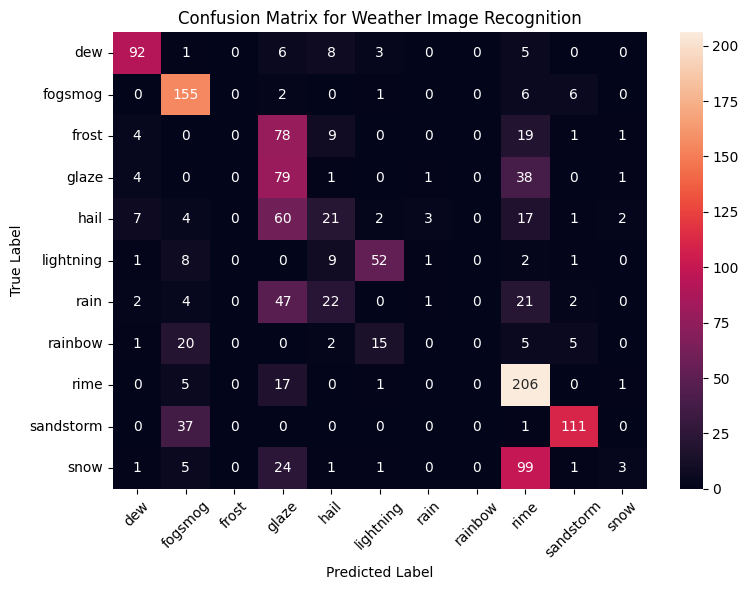

In [22]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data = con_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title("Confusion Matrix for Weather Image Recognition")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
#multi-class classification report
print(classification_report(actual_classes,predicted_classes))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       115
           1       0.65      0.91      0.76       170
           2       0.00      0.00      0.00       112
           3       0.25      0.64      0.36       124
           4       0.29      0.18      0.22       117
           5       0.69      0.70      0.70        74
           6       0.17      0.01      0.02        99
           7       0.00      0.00      0.00        48
           8       0.49      0.90      0.63       230
           9       0.87      0.74      0.80       149
          10       0.38      0.02      0.04       135

    accuracy                           0.52      1373
   macro avg       0.42      0.45      0.40      1373
weighted avg       0.46      0.52      0.45      1373



c:\Users\Shivam\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shivam\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shivam\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Here, the train accuracy is less than test accuracy and the accuracy scores suggests that the CNN is underfitting. Let us add one more convolutional layer to increasse the accuracy.

## CNN with 2 Convolutional Layer

We will use the following structure of CNN which has 2 convolutional layers and a max-pooling layer:

$$
    \text{Conv}\rightarrow\text{Conv}\rightarrow\text{MaxPool}\rightarrow\text{Linear}\rightarrow\text{Output Layer}
$$

We will regularize the model to prevent overfitting using dropout.

### Building CNN

In [24]:
#CNN with 2 convolutional layer
class CNN_2(nn.Module):
    def __init__(self, num_classes):
        super(CNN_2, self).__init__()
        
        # Input size is [32, 3, 160, 160]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)    # convolutional layer with 32 filters of size 3x3 and added padding
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)   # convolutional layer with 32 filters of size 3x3 and added padding
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Output size after conv & pool depends on input size. For 160x160 input:
        # Conv1: 160 → 160
        # Conv2: 160 → 160
        # Pool: 160 → 80
        self.flattened_size = 32 * 80 * 80

        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 32, 160, 160]
        x = F.relu(self.conv2(x))   # [B, 32, 160, 160]
        x = self.pool(x)            # [B, 32, 80, 80]

        x = x.view(x.size(0), -1)   # Flatten → [B, 32x80x80]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             896
            Conv2d-2         [-1, 32, 160, 160]           9,248
         MaxPool2d-3           [-1, 32, 80, 80]               0
            Linear-4                  [-1, 100]      20,480,100
           Dropout-5                  [-1, 100]               0
            Linear-6                   [-1, 11]           1,111
Total params: 20,491,355
Trainable params: 20,491,355
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 14.06
Params size (MB): 78.17
Estimated Total Size (MB): 92.53
----------------------------------------------------------------


### Training CNN

In [26]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()                                   # Clears old gradients from the previous batch
        loss.backward()                                         # Performs backpropagation
        optimizer.step()                                        # Updates weights

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")   # accuracy after every epoch


Epoch 1: Loss = 305.3933, Accuracy = 45.40%
Epoch 2: Loss = 203.8088, Accuracy = 60.61%
Epoch 3: Loss = 174.5081, Accuracy = 66.72%
Epoch 4: Loss = 149.0437, Accuracy = 71.03%
Epoch 5: Loss = 128.9644, Accuracy = 74.75%
Epoch 6: Loss = 118.1550, Accuracy = 77.54%
Epoch 7: Loss = 104.7856, Accuracy = 80.09%
Epoch 8: Loss = 94.4458, Accuracy = 81.56%
Epoch 9: Loss = 87.8521, Accuracy = 83.11%
Epoch 10: Loss = 85.4393, Accuracy = 84.06%


### Predicting using trained CNN

In [27]:
model.eval()
correct, total = 0, 0
predicted_classes = []
actual_classes = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        actual_classes.extend(labels.cpu().numpy())
        outputs = model(images)
        _, preds = torch.max(outputs, 1)                        # returns the label of the images
        predicted_classes.extend(preds.cpu().numpy())
        correct += (preds == labels).sum().item()               # returns the number of correctly classified images
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")           # accuracy score of the model

Test Accuracy: 69.77%


In [28]:
# creating confusion matrix
con_matrix = confusion_matrix(actual_classes, predicted_classes)
con_matrix

array([[ 98,   2,   4,   0,   4,   4,   0,   0,   1,   1,   1],
       [  0, 143,   0,   0,   0,   2,   0,   0,   3,  17,   5],
       [ 10,   1,  48,  12,  16,   1,   3,   0,  10,   1,  10],
       [  2,   1,  13,  72,   9,   1,   4,   0,  18,   0,   4],
       [ 10,   2,  10,   6,  68,   1,   2,   0,   5,   3,  10],
       [  0,   5,   0,   1,   0,  60,   0,   7,   1,   0,   0],
       [  3,   7,   1,   3,  10,   1,  55,   1,   1,   3,  14],
       [  1,   8,   0,   0,   1,   3,   0,  27,   2,   6,   0],
       [  1,   4,   1,  11,   3,   3,   1,   0, 175,   1,  30],
       [  0,  17,   0,   0,   0,   1,   0,   3,   0, 128,   0],
       [  2,   3,   4,   6,   5,   1,   5,   0,  24,   1,  84]])

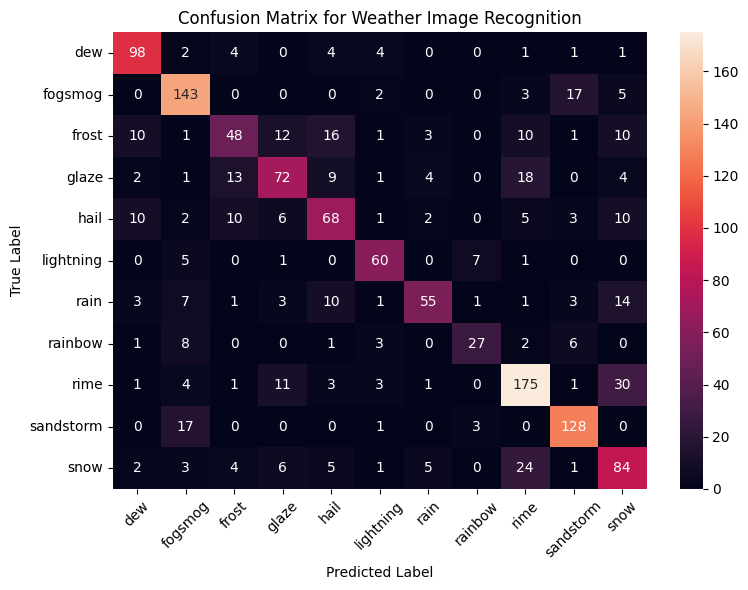

In [29]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data = con_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title("Confusion Matrix for Weather Image Recognition")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
#multi-class classification report
print(classification_report(actual_classes,predicted_classes))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       115
           1       0.74      0.84      0.79       170
           2       0.59      0.43      0.50       112
           3       0.65      0.58      0.61       124
           4       0.59      0.58      0.58       117
           5       0.77      0.81      0.79        74
           6       0.79      0.56      0.65        99
           7       0.71      0.56      0.63        48
           8       0.73      0.76      0.74       230
           9       0.80      0.86      0.83       149
          10       0.53      0.62      0.57       135

    accuracy                           0.70      1373
   macro avg       0.70      0.68      0.68      1373
weighted avg       0.70      0.70      0.69      1373



This CNN with 2 convolutional layers has training accuracy significantly larger than its test accuracy, suggesting that the CNN is overfitting the training data. Let us now regularize the model using hyperparameter tuning. 

## Regularizing CNN using hyperparameter tuning

### Building CNN with hyeperparameters

Define a CNN model with the following hyperparameters:
  
- Dropout rate after hidden layer  
- Learning rate of Adam optimizer

In [31]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout):          #hyperparameters
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)    # convolutional layer with 32 filters of size 3x3 and added padding
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)   # convolutional layer with 32 filters of size 3x3 and added padding
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.flattened_size = 32 * 80 * 80
        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

### Defining parameter grid and tuning CNN

In [32]:
dropout_vals = [0.2,0.3,0.4]
lr_vals = [1e-4,1e-3,1e-2]

param_grid = list(itertools.product(dropout_vals, lr_vals))

The following code block performs hyperparameter tuning on the parameter grid defined by `param_grid`. The hyperparameters with best validation accuracy is then selected for training.

In [33]:
num_epochs = 5
batch_size = 32
best_val_acc = 0
best_config = None

# loop over each hyperparameter combination
for i, (drop, lr) in enumerate(param_grid):
    print(f"\nTesting config {i+1}/{len(param_grid)}:")
    print(f"Dropout={drop}, LR={lr}")

    # split training data into training and validation subsets (reshuffled each run)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

    # create data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # initialize CNN with current hyperparameters
    model = CNN(num_classes, drop).to(device)
    
    # setup optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # train model for specified number of epochs
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()  # clear previous gradients
            loss.backward()        # backpropagate loss
            optimizer.step()       # update model weights

    # evaluate model on validation set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # calculate and print validation accuracy
    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    # save model and config if this one is the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = (drop, lr)
        best_model = deepcopy(model)



Testing config 1/9:
Dropout=0.2, LR=0.0001
Validation Accuracy: 71.13%

Testing config 2/9:
Dropout=0.2, LR=0.001
Validation Accuracy: 63.39%

Testing config 3/9:
Dropout=0.2, LR=0.01
Validation Accuracy: 16.67%

Testing config 4/9:
Dropout=0.3, LR=0.0001
Validation Accuracy: 67.40%

Testing config 5/9:
Dropout=0.3, LR=0.001
Validation Accuracy: 64.03%

Testing config 6/9:
Dropout=0.3, LR=0.01
Validation Accuracy: 17.12%

Testing config 7/9:
Dropout=0.4, LR=0.0001
Validation Accuracy: 67.85%

Testing config 8/9:
Dropout=0.4, LR=0.001
Validation Accuracy: 65.12%

Testing config 9/9:
Dropout=0.4, LR=0.01
Validation Accuracy: 18.40%


### Best parameters

In [34]:
# best hyperparameters after tuning
best_dropout = best_config[0]
best_lr = best_config[1]

print("\nBest Config:")
print(f"Dropout={best_dropout}, LR={best_lr}")
print(f"Validation Accuracy: {best_val_acc:.2f}%")


Best Config:
Dropout=0.2, LR=0.0001
Validation Accuracy: 71.13%


### Training Best CNN

The model with best hyperparameters is described in the ouput of the following codeblock.

In [35]:
model = CNN(num_classes, best_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

summary(model, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             896
            Conv2d-2         [-1, 32, 160, 160]           9,248
         MaxPool2d-3           [-1, 32, 80, 80]               0
            Linear-4                  [-1, 100]      20,480,100
           Dropout-5                  [-1, 100]               0
            Linear-6                   [-1, 11]           1,111
Total params: 20,491,355
Trainable params: 20,491,355
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 14.06
Params size (MB): 78.17
Estimated Total Size (MB): 92.53
----------------------------------------------------------------


In [36]:
#training best CNN
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()                                   # clears old gradients from the previous batch
        loss.backward()                                         # performs backpropagation
        optimizer.step()                                        # updates weights

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")  # accuracy after every epoch

Epoch 1: Loss = 217.9525, Accuracy = 48.30%
Epoch 2: Loss = 171.7934, Accuracy = 60.08%
Epoch 3: Loss = 149.8051, Accuracy = 64.70%
Epoch 4: Loss = 139.1515, Accuracy = 66.84%
Epoch 5: Loss = 130.3156, Accuracy = 68.75%
Epoch 6: Loss = 122.8757, Accuracy = 70.51%
Epoch 7: Loss = 116.5745, Accuracy = 73.08%
Epoch 8: Loss = 107.7402, Accuracy = 74.29%
Epoch 9: Loss = 102.0827, Accuracy = 75.86%
Epoch 10: Loss = 96.6901, Accuracy = 76.54%


### Predicting using trained CNN

In [37]:
model.eval()
correct, total = 0, 0
predicted_classes = []
actual_classes = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        actual_classes.extend(labels.cpu().numpy())
        outputs = model(images)
        _, preds = torch.max(outputs, 1)                        # returns the label of the images
        predicted_classes.extend(preds.cpu().numpy())
        correct += (preds == labels).sum().item()               # returns the number of correctly classified images
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")           # accuracy score of the model

Test Accuracy: 70.65%


In [38]:
# creating confusion matrix
con_matrix = confusion_matrix(actual_classes, predicted_classes)
con_matrix

array([[ 98,   1,   3,   1,   4,   3,   2,   0,   1,   1,   1],
       [  0, 145,   0,   0,   0,   2,   0,   1,  12,  10,   0],
       [ 15,   1,  38,  26,  11,   0,   3,   0,  13,   2,   3],
       [  3,   2,   7,  80,   4,   0,   4,   0,  18,   2,   4],
       [  7,   4,   5,  10,  69,   2,   5,   0,   4,   4,   7],
       [  3,   7,   0,   0,   1,  54,   1,   3,   1,   3,   1],
       [  6,   4,   2,   6,   5,   0,  59,   2,   9,   1,   5],
       [  2,   5,   0,   1,   0,   5,   0,  25,   2,   8,   0],
       [  0,   3,   3,  10,   3,   3,   2,   0, 196,   0,  10],
       [  0,  12,   0,   0,   0,   1,   0,   1,   2, 133,   0],
       [  1,   2,   5,  11,   3,   1,   5,   0,  33,   1,  73]])

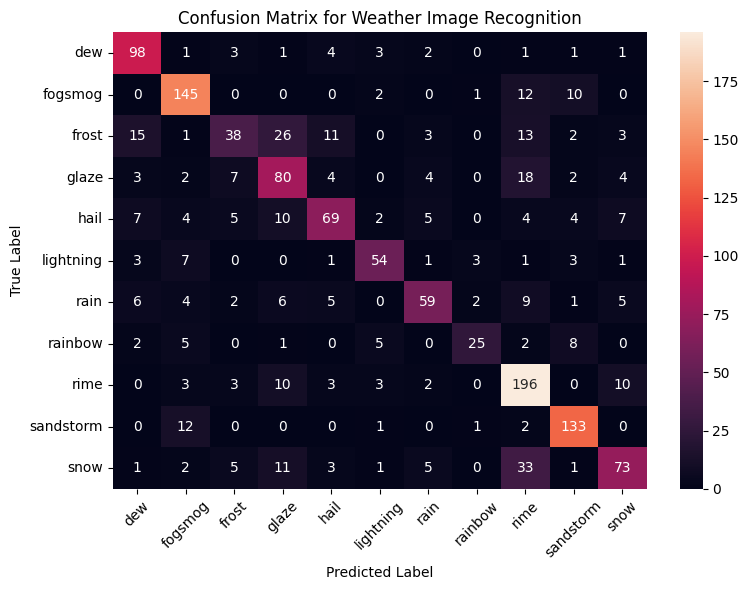

In [39]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data = con_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title("Confusion Matrix for Weather Image Recognition")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
#multi-class classification report
print(classification_report(actual_classes,predicted_classes))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78       115
           1       0.78      0.85      0.81       170
           2       0.60      0.34      0.43       112
           3       0.55      0.65      0.59       124
           4       0.69      0.59      0.64       117
           5       0.76      0.73      0.74        74
           6       0.73      0.60      0.66        99
           7       0.78      0.52      0.62        48
           8       0.67      0.85      0.75       230
           9       0.81      0.89      0.85       149
          10       0.70      0.54      0.61       135

    accuracy                           0.71      1373
   macro avg       0.71      0.67      0.68      1373
weighted avg       0.71      0.71      0.70      1373



## Transfer Learning

Accuracy of CNN can be improved by adding more convolutional layers. However, training a CNN from scratch can be slow and tricky — especially because the gradients in the early layers can vanish, making it harder for the model to learn effectively. To avoid this, we use pretrained models and the idea of transfer learning. Instead of training the whole network from scratch, we reuse the first few layers from a model that’s already learned useful features (like edges, shapes, and textures), and only train the later layers for our specific task.

### ResNet-18

ResNet18 is a deep convolutional neural network with 18 layers, known for introducing residual connections (or skip connections) that help solve the vanishing gradient problem and allow training of deeper networks. We use the pretrained ResNet-18 model available within the `torchvision.models` library.

#### Building the model

In [17]:
ResNet18 = models.resnet18(weights='DEFAULT',progress=True)
summary(ResNet18,input_size=(3,160,160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          36,864
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
       BasicBlock-11           [-1, 64, 40, 40]               0
           Conv2d-12           [-1, 64, 40, 40]          36,864
      BatchNorm2d-13           [-1, 64, 40, 40]             128
             ReLU-14           [-1, 64,

The architecture of ResNet18, a deep convolutional neural network with ~11.7 million parameters is described above. It consists of multiple residual blocks grouped into four stages, increasing number of filters (from 64 to 512) with each stage, and ends with a global average pooling layer followed by a fully connected layer. Despite its depth, the use of skip connections helps it remain efficient and trainable.

#### Freezing all layers except the final layer

In [18]:
for param in ResNet18.parameters():
    param.requires_grad = False

for param in ResNet18.fc.parameters():
    param.requires_grad = True

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ResNet18 = ResNet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18.parameters(), lr=0.001)

summary(ResNet18, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          36,864
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
       BasicBlock-11           [-1, 64, 40, 40]               0
           Conv2d-12           [-1, 64, 40, 40]          36,864
      BatchNorm2d-13           [-1, 64, 40, 40]             128
             ReLU-14           [-1, 64,

Note that since we freezed the layers except the last layer, the number of trainable parameters has reduced significantly.

#### Training the model

In [20]:
#training the model
num_epochs = 10

for epoch in range(num_epochs):
    ResNet18.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = ResNet18(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()                                   # clears old gradients from the previous batch
        loss.backward()                                         # performs backpropagation
        optimizer.step()                                        # updates weights

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")   # accuracy after every epoch

Epoch 1: Loss = 473.2547, Accuracy = 34.65%
Epoch 2: Loss = 175.1259, Accuracy = 66.72%
Epoch 3: Loss = 129.7194, Accuracy = 74.75%
Epoch 4: Loss = 112.3974, Accuracy = 78.25%
Epoch 5: Loss = 100.6257, Accuracy = 80.51%
Epoch 6: Loss = 96.0675, Accuracy = 81.27%
Epoch 7: Loss = 88.7835, Accuracy = 82.36%
Epoch 8: Loss = 85.5993, Accuracy = 82.84%
Epoch 9: Loss = 83.2683, Accuracy = 83.95%
Epoch 10: Loss = 81.6933, Accuracy = 84.15%


#### Predicting using ResNet-18

In [21]:
ResNet18.eval()
correct, total = 0, 0
predicted_classes = []
actual_classes = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        actual_classes.extend(labels.cpu().numpy())
        outputs = ResNet18(images)
        _, preds = torch.max(outputs, 1)                        # returns the label of the images
        predicted_classes.extend(preds.cpu().numpy())
        correct += (preds == labels).sum().item()               # returns the number of correctly classified images
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")           # accuracy score of the model

Test Accuracy: 82.81%


In [23]:
# creating confusion matrix
con_matrix = confusion_matrix(actual_classes, predicted_classes)
con_matrix

array([[116,   1,   4,   6,   3,   1,   0,   0,   1,   1,   1],
       [  0, 134,   0,   2,   0,   1,   5,   0,   1,   5,   4],
       [  4,   1,  53,  15,   3,   1,   0,   0,   9,   0,   5],
       [  4,   1,   5,  92,   3,   0,   0,   0,  15,   0,  12],
       [  3,   0,   1,   0,  99,   0,   2,   0,   0,   0,   3],
       [  0,   1,   0,   0,   0,  72,   0,   0,   0,   0,   0],
       [  1,   4,   1,   2,   3,   0,  84,   0,   1,   3,   3],
       [  0,   2,   0,   0,   0,   0,   0,  38,   1,   1,   0],
       [  0,   2,   1,  12,   0,   0,   0,   1, 221,   3,  23],
       [  0,  15,   0,   0,   0,   1,   1,   0,   0, 118,   2],
       [  0,   7,   0,   5,   3,   0,   4,   0,   8,   2, 110]])

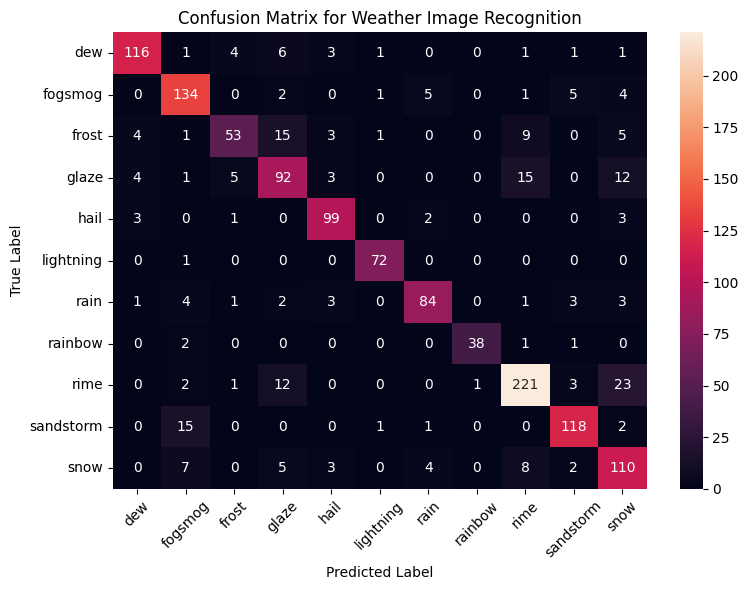

In [24]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data = con_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title("Confusion Matrix for Weather Image Recognition")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
#multi-class classification report
print(classification_report(actual_classes,predicted_classes))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       134
           1       0.80      0.88      0.84       152
           2       0.82      0.58      0.68        91
           3       0.69      0.70      0.69       132
           4       0.87      0.92      0.89       108
           5       0.95      0.99      0.97        73
           6       0.88      0.82      0.85       102
           7       0.97      0.90      0.94        42
           8       0.86      0.84      0.85       263
           9       0.89      0.86      0.87       137
          10       0.67      0.79      0.73       139

    accuracy                           0.83      1373
   macro avg       0.84      0.83      0.84      1373
weighted avg       0.83      0.83      0.83      1373



The running time of ResNet18 is comparable to the earlier custom CNN with two convolutional layers. However, ResNet18 achieves higher accuracy due to its deeper architecture and the advantage of pretrained feature extraction.